In [103]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import pandas as pd
from scipy.optimize import bisect
from scipy.stats import linregress
import seaborn as sns
from collections import deque

In [3]:
def I(sigma, S_0 = 100 , K = 120, r = 0.05, T = 0.2):
    """Closed form solution of an european put option of a geometric brownian motion with equidistant time steps adjusted to the market price
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    I_market : float
        Market price of such put options
    S_0 : float
        Initial value of the geometric brownian motion
    K : float
        strike price of the put option
    r : float
        interest rate of the put option
    sigma : float
        volatility of the geometric brownian motion
    T : float
        time horizon of the put option

    Returns
    -------
    I : float
        Mark to market price of the put option"""
    
    w = (np.log(K/S_0) - (r-0.5*sigma**2)*T) / ( sigma * np.sqrt(T) )
    I = np.exp(-r*T) * K * st.norm.cdf(w) - S_0 * st.norm.cdf(w - sigma*np.sqrt(T))
    return I

def Simulate_Stock_Price(S_0,sigma, r, T, m,N):
    """This function returns m GBM, each evaluated at time t starting at s_0

    Parameters
    ----------
    s_0 : float
        Initial value of the geometric Brownian motion
    sigma : float
        Volatility of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    t : float
        Time horizon of the geometric Brownian motion
    N : int
        Number of GBM to generate

    Returns
    -------
    S : np.ndarray
        m GBM evaluated at time t (m_features,)
    """
    simulations = np.ndarray((N, m))
    expXt = st.lognorm.rvs(s=np.sqrt(sigma**2 * T / m), loc=0, scale=np.exp((r - 0.5 * sigma**2) * T / m), size=m*N)
    expXt_reshaped = expXt.reshape((N, m))
    simulations = np.cumprod(np.concatenate([np.ones((N, 1)) * S_0, expXt_reshaped], axis=1), axis=1)
    return simulations[:, 1:]

def RM_European(n, N, rho, K, S0, T, r, I_market):
    sigma_0=1
    alpha_0=2/(K+S0)
    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Compute Jhat
        stock_prices = Simulate_Stock_Price(S0, sigma_cur, r, T, m=1, N=N)
        payoffs = np.exp(-r*T) * np.maximum(K - stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

Calculate the 'true' implied volatility

In [4]:
I_m = 22
sigma_opt = bisect(lambda sigma: I(sigma) - I_m, 0.01, 10)
print(sigma_opt)

0.508372926009589


Apply RM Algorithm to find the implied volality. Estimation of the Mean Squared Error (MSE).

rho = 0.5, N = 1, Convergence Rate: 0.6766948012600512
rho = 0.5, N = 10, Convergence Rate: 1.042471429220609
rho = 0.5, N = 100, Convergence Rate: 1.7344514691966262
rho = 0.8, N = 1, Convergence Rate: 0.7038445874340852
rho = 0.8, N = 10, Convergence Rate: 0.7757497595824474
rho = 0.8, N = 100, Convergence Rate: 0.7834202198583876
rho = 1, N = 1, Convergence Rate: 0.27713037616883884
rho = 1, N = 10, Convergence Rate: 0.28858625561179885
rho = 1, N = 100, Convergence Rate: 0.29101084624195445


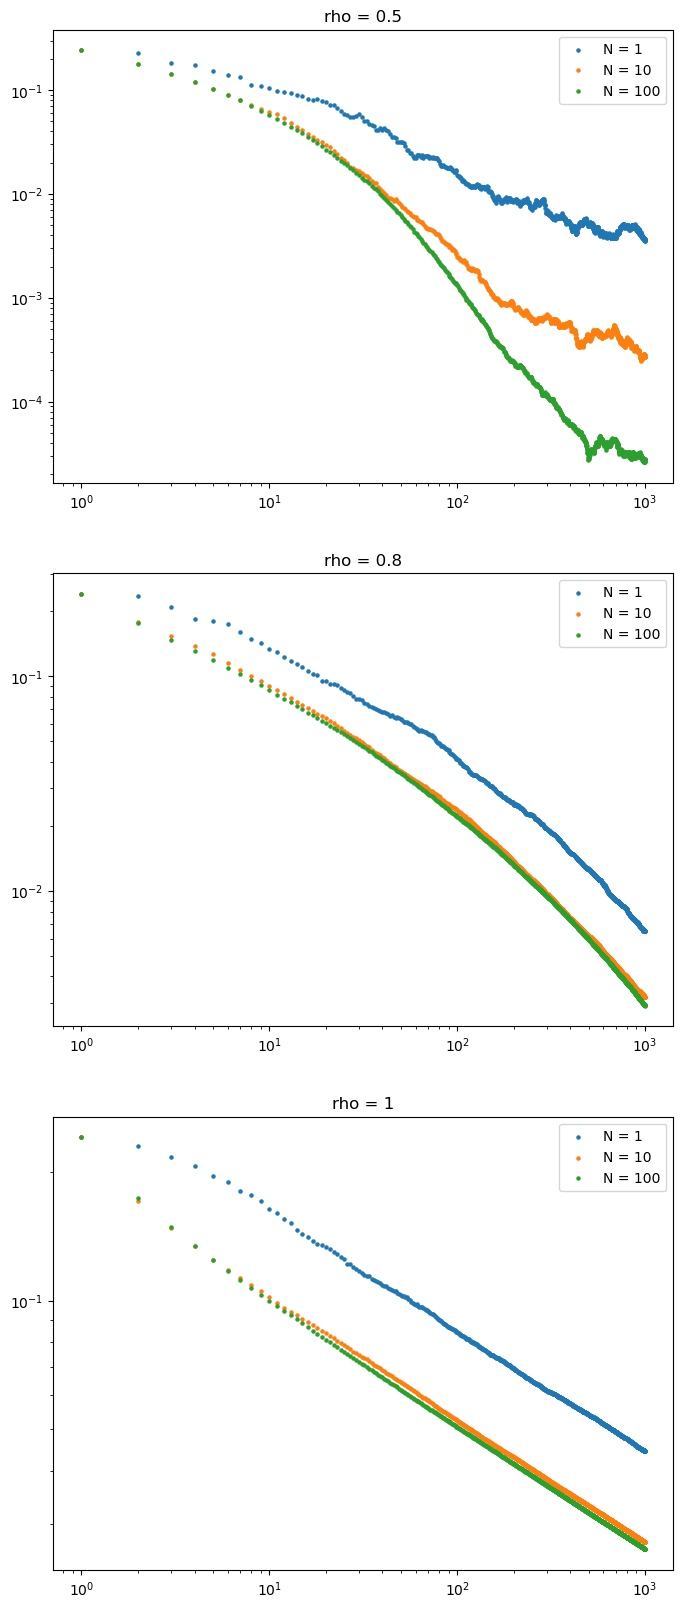

In [189]:
n = 1000
iterations = 100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
rhos = [0.5,0.8,1]
fig, axs = plt.subplots(3, 1, figsize=(8,20))
for i, rho in enumerate(rhos):
    ax = axs[i]
    for N in [1,10,100]:
        # Estimate expectation of MSE
        all_sigma_estim = np.empty((iterations,n))
        for i in range(iterations):
            all_sigma_estim[i] = RM_European(n, N, rho, K, S0, T, r, I_market)
        MSE = np.mean((all_sigma_estim - sigma_opt)**2, axis=0)
        ax.scatter(np.arange(1,n+1), MSE, label='N = ' + str(N), s=5)

        #  Calculate convergence rate
        log_n_iterations = np.log(np.arange(1,n+1))
        log_errors = np.log(MSE)
        convergence_rate =  - linregress(log_n_iterations, log_errors)[0]
        print('rho = ' + str(rho) + ', N = ' + str(N) + ', Convergence Rate: ' + str(convergence_rate))
        
    ax.set_title('rho = ' + str(rho))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    # ax.set_xlabel('n')
    # ax.set_ylabel('MSE')

Text(0, 0.5, 'MSE')

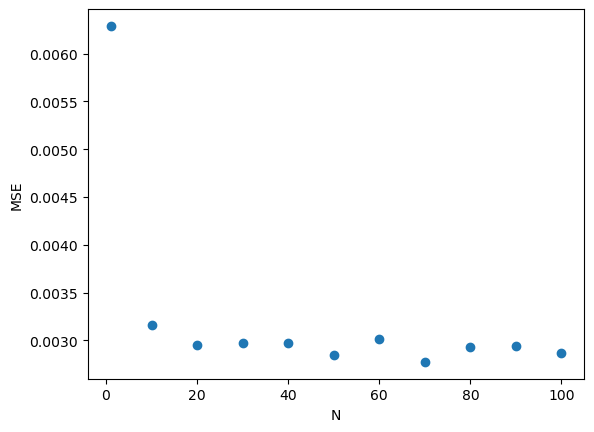

In [190]:
n = 1000
iterations = 100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
rho = 0.8
Ns = [1,10,20,30,40,50,60,70,80,90,100]
MSE = np.empty((len(Ns),))
for j, N in enumerate(Ns):
    # Estimate expectation of MSE
    all_sigma_estim = np.empty((iterations,))
    for i in range(iterations):
        all_sigma_estim[i] = RM_European(n, int(N), rho, K, S0, T, r, I_market)[-1]
    MSE[j] = np.mean((all_sigma_estim - sigma_opt)**2)
plt.scatter(Ns, MSE)
plt.xlabel('N')
plt.ylabel('MSE')

RM Algorithm to find implied volatility for Asian put option with I_market = 22

In [5]:
def RM_Asian(n, N, rho, K, S0, T, r, I_market, m):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(Z) - I_market
        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

In [192]:
def RM_Asian_with_Stopping(N, rho, K, S0, T, r, I_market, m):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)
    
    sigma_cur = sigma_0
    i = 1
    
    while True:
        alpha_n = alpha_0 / i ** rho

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        Jhat, est_std = np.mean(Z), np.std(Z)
        sigma_cur = sigma_cur - alpha_n * Jhat
        i += 1

        # Stopping Criterion
        margin = 1.96 * est_std / np.sqrt(N)
        if abs(alpha_n * Jhat) < 10**(-8) and margin < 1 and Jhat - margin < 0 and 0 < Jhat + margin:
            break

    return sigma_cur, i, Jhat, est_std, 1.96 * est_std / np.sqrt(N)

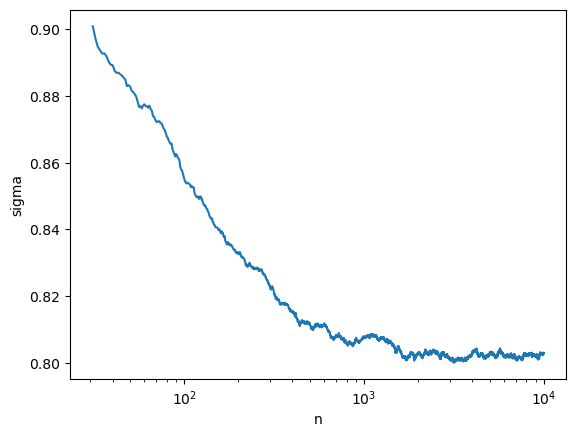

In [195]:
n=10000
N=1000
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22

plt.figure()
sigmas = RM_Asian(n, N, rho=0.5, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30)
plt.plot(range(31,n+1), sigmas[30:])
plt.xlabel('n')
plt.ylabel('sigma')
plt.xscale('log')

# t = RM_Asian_with_Stopping(N, rho=0.6, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30, sigma_0=1)
# print(t)

In [164]:
def Jhat_Asian(sigma, avg_stock_prices = None):
    if not avg_stock_prices:
        simulations = Simulate_Stock_Price(S0, sigma, r, T, m=30, N=N)
        avg_stock_prices = np.mean(simulations, axis=1)
    Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
    return np.mean(Z), np.std(Z), st.skew(Z)

sigma = 0.803023808316087
N=1000
Jhat, est_std, est_skew = Jhat_Asian(sigma)
margin = 1.96 * est_std / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin

# Print the confidence interval
print(f"CLT 95% Confidence Interval: ({lower_bound}, {upper_bound})")

margin = est_std / np.sqrt(0.05*N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Chebyshev
print(f"Chebyshev 95% Confidence Interval: ({lower_bound}, {upper_bound})")

k = 0.4748
xalpha = st.norm.ppf(k * est_std*est_skew**3/(np.sqrt(N) * est_std**3) + 1 - 0.05/2)
margin = xalpha * est_std / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Barry-Essen
print(f"Barry-Essen 95% Confidence Interval: ({lower_bound}, {upper_bound})")


CLT 95% Confidence Interval: (-1.2883263614692413, 0.7588978184511728)
Chebyshev 95% Confidence Interval: (-2.6002920426739857, 2.0708634996559176)
Barry-Essen 95% Confidence Interval: (-1.2883148747368662, 0.7588863317187977)


In [165]:
def calculate_bounds(r, T, S0, K, m):
    diff = K - S0 * np.mean(np.exp(r * np.arange(1,m+1) * T / m))
    diff = diff if diff > 0 else 0
    return str((np.exp(-r*T)*diff, np.exp(-r*T)*K))

print('Old bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=120, m=30))
print('New bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=80, m=30))

Old bounds for I_market: (19.28773300985098, 118.80598004990017)
New bounds for I_market: (0.0, 79.20398669993345)


In [111]:
def RM_Asian_with_Stopping(N, rho, K, S0, T, r, I_market, m):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)
    
    sigma_cur = sigma_0
    sigma_estim = deque([sigma_0])
    J_estim = deque([])
    window_size = 1000

    i = 1
    
    while True:
        alpha_n = alpha_0 / i ** rho

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        Jhat, est_std = np.mean(Z), np.std(Z)
        sigma_cur = sigma_cur - alpha_n * Jhat
        sigma_estim.append(sigma_cur)
        J_estim.append(Jhat)

        # Stopping Criterion
        if i == window_size:
            mean_value = np.mean(J_estim)
        if i > window_size:
            removed_value = J_estim.popleft()
            mean_value = mean_value + (Jhat - removed_value) / window_size
            if abs(mean_value) < 10**(-3) and abs(Jhat) < 10**(-2):
                break
        i += 1

    print(f'Stopped at iteration n = {i}, where sigma_n = {sigma_cur}')
    return sigma_estim

In [113]:
# Question 6: Important Sampling

# Part a) Use IS to approximate I(sigma). Note: Jhat(sigma) = Ihat(sigma) - I_market

# Calculate likelihood ratio
def w(S_T, S_0, sigma, r, r_tilde, T):
    return (S_T/S_0)**((r - r_tilde)/sigma**2) * np.exp((r+r_tilde-sigma**2)*(-r+r_tilde)*T/(2*sigma**2))

def RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)
    
    if n:
        sigma_estim = np.empty((n,))
        sigma_cur = sigma_0
        
        for i in range(1, n):
            alpha_n = alpha_0 / i ** rho

            # Calculate Jhat with IS
            simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
            likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
            avg_stock_prices = np.mean(simulations, axis=1)
            payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
            Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market

            sigma_cur = sigma_cur - alpha_n * Jhat
            sigma_estim[i] = sigma_cur
    else:
        sigma_cur = sigma_0
        sigma_estim = deque([sigma_0])
        J_estim = deque([])
        window_size = 1000
        i = 1
        while True:
            alpha_n = alpha_0 / i ** rho

            # Calculate Jhat
            simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
            likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
            avg_stock_prices = np.mean(simulations, axis=1)
            payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
            Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market
            sigma_cur = sigma_cur - alpha_n * Jhat
            sigma_estim.append(sigma_cur)
            J_estim.append(Jhat)

            # Stopping Criterion
            if i == window_size:
                mean_value = np.mean(J_estim)
            if i > window_size:
                removed_value = J_estim.popleft()
                mean_value = mean_value + (Jhat - removed_value) / window_size
                if abs(mean_value) < 10**(-3) and abs(Jhat) < 10**(-2):
                    break
            i += 1

        print(f'Stopped at iteration n = {i}, where sigma_n = {sigma_cur}')
    return sigma_estim

In [211]:
n, N, rho = None, 10, 0.6
K, S0, T, r, I_market = 80, 100, 0.2, 0.05, 3
r_tilde = -2.6
m = 50

sigmas_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m)
sigmas = RM_Asian_with_Stopping(N, rho, K, S0, T, r, I_market, m)

Stopped at iteration n = 8095, where sigma_n = 1.1114575695074114
Stopped at iteration n = 28651, where sigma_n = 1.1122563889614268


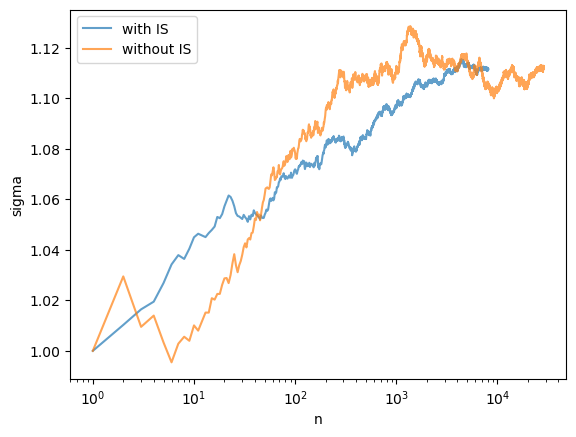

In [212]:
plt.plot(range(1, len(sigmas_IS)+1), sigmas_IS, label="with IS", alpha=0.7)
plt.plot(range(1, len(sigmas)+1), sigmas, label="without IS", alpha=0.7)

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()

plt.xscale('log')

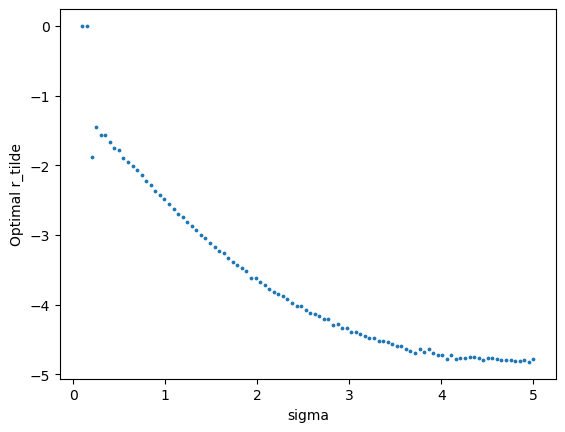

In [104]:
# Question 7
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d

K, S0, T, r = 80, 100, 0.2, 0.05
m = 50
N = 100000
def find_optimal_r_tilde(sigmas, S0, K, r, T, m, N):
    def g(eta, sigma, simulations):
        likelihood_ratios = w(simulations[:, -1], S0, sigma, r, eta, T)
        
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs_squared = (np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0))**2
        variance = np.mean(np.multiply(payoffs_squared, likelihood_ratios))
        return variance
    
    if type(sigmas) == float:
        simulations = Simulate_Stock_Price(S0, sigma, r, T, m, N)
        return minimize_scalar(g, args=(sigmas,simulations)).x
    else:
        result = np.empty((len(sigmas),))
        for i, sigma in enumerate(sigmas):
            simulations = Simulate_Stock_Price(S0, sigma, r, T, m, N)
            result[i] = minimize_scalar(g, args=(sigma,simulations)).x

        return result
sigmas = np.linspace(0.1, 5, num=100)
result = find_optimal_r_tilde(sigmas, S0, K, r, T, m, N)
plt.scatter(sigmas, result, s=3)
plt.xlabel('sigma')
plt.ylabel('Optimal r_tilde')

# Spline interpolation
spline_interp = interp1d(sigmas, result, kind='cubic')

In [124]:
def RM_Asian_with_IS_opt(n, N, rho, K, S0, T, r, I_market, m):
    sigma_0 = 1
    alpha_0 = 2/(K+S0)
    
    if n is not None:
        sigma_estim = np.empty((n,))
        sigma_cur = sigma_0
        
        for i in range(1, n):
            alpha_n = alpha_0 / i ** rho

            # Calculate Jhat with IS
            r_tilde = spline_interp(sigma_cur)
            simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
            likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
            avg_stock_prices = np.mean(simulations, axis=1)
            payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
            Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market

            sigma_cur = sigma_cur - alpha_n * Jhat
            sigma_estim[i] = sigma_cur
    else:
        sigma_cur = sigma_0
        sigma_estim = deque([sigma_0])
        J_estim = deque([])
        window_size = 1000
        i=1
        while True:
            alpha_n = alpha_0 / i ** rho

            # Calculate Jhat
            r_tilde = spline_interp(sigma_cur)
            simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
            likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
            avg_stock_prices = np.mean(simulations, axis=1)
            payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
            Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market
            sigma_cur = sigma_cur - alpha_n * Jhat
            sigma_estim.append(sigma_cur)
            J_estim.append(Jhat)

            # Stopping Criterion
            if i == window_size:
                mean_value = np.mean(J_estim)
            if i > window_size:
                removed_value = J_estim.popleft()
                mean_value = mean_value + (Jhat - removed_value) / window_size
                if abs(mean_value) < 10**(-3) and abs(Jhat) < 10**(-2):
                    break
            i += 1
        print(f'Stopped at iteration n = {i}, where sigma_n = {sigma_cur}')
    return sigma_estim

In [241]:
n, N, rho = 10**4, 10, 0.55
K, S0, T, r, I_market = 80, 100, 0.2, 0.05, 3
r_tilde = -2.6
m = 50

sigmas_IS_opt = RM_Asian_with_IS_opt(n, N, rho, K, S0, T, r, I_market, m)
sigmas_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m)
sigmas = RM_Asian(n, N, rho, K, S0, T, r, I_market, m)

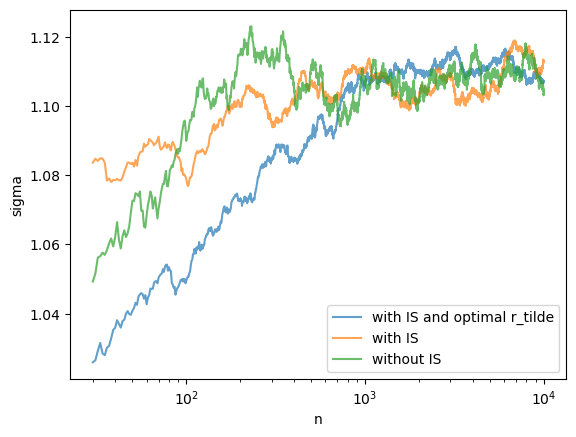

In [240]:
plt.plot(range(30,len(sigmas_IS_opt)), sigmas_IS_opt[30:], label="with IS and optimal r_tilde", alpha=0.7)
plt.plot(range(30,len(sigmas_IS)), sigmas_IS[30:], label="with IS", alpha=0.7)
plt.plot(range(30,len(sigmas)), sigmas[30:], label="without IS", alpha=0.7)

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()

plt.xscale('log')

In [237]:
class VarianceAnalyzer:
    def __init__(self, window_size):
        self.window_size = window_size
        self.values = []

    def update(self, new_value):
        self.values.append(new_value)
        if len(self.values) > self.window_size:
            self.values.pop(0)
            return self.calculate_std()
        return 0

    def calculate_std(self):
        if len(self.values) < 2:
            return None  # Variance is undefined with less than two values
        return np.var(self.values, ddof=1)  # ddof=1 for unbiased variance estimation

window_size = 5000
variance_analyzer = VarianceAnalyzer(window_size)

variance_1 = [variance_analyzer.update(value) for value in sigmas_IS_opt]
variance_2 = [variance_analyzer.update(value) for value in sigmas_IS]
variance_3 = [variance_analyzer.update(value) for value in sigmas]


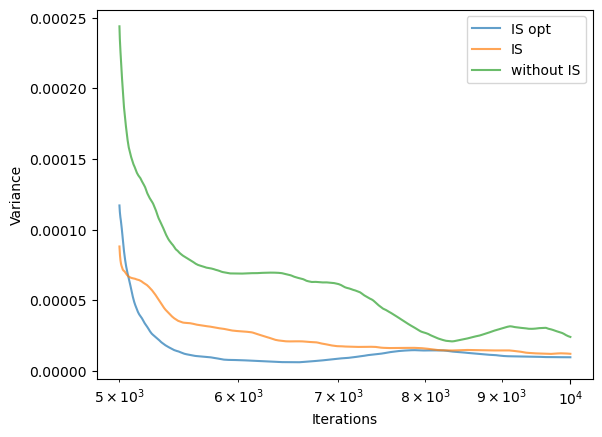

In [238]:
plt.plot(range(window_size, len(variance_1)), variance_1[window_size:], label='IS opt', alpha=0.7)
plt.plot(range(window_size, len(variance_2)), variance_2[window_size:], label='IS', alpha=0.7)
plt.plot(range(window_size, len(variance_3)), variance_3[window_size:], label='without IS', alpha=0.7)

plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.xscale('log')
plt.legend()
plt.show()